# Design Spike sequences for experiments
This Python Jupyter notebook designs plasmids for the Spikes designated for annotation in the configuration.

## Imports and configuration
Import modules and read configuration file:

In [1]:
import copy
import itertools
import os

import Bio.Alphabet.IUPAC
import Bio.Seq
import Bio.SeqFeature
import Bio.SeqIO
import Bio.SeqRecord

import dna_features_viewer

import editdistance

from IPython.display import display, HTML

import pandas as pd

from plotnine import *

import pdb_prot_align.utils

import yaml

Read configuration:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory:

In [3]:
os.makedirs(config['seqs_for_expts_dir'], exist_ok=True)

## Get Spikes for experiments
Get names of Spikes for which we perform experiments as indicated in the configuration:

In [4]:
metadata = pd.read_csv(config['spikes_metadata'])

with open(config['accessions_special']) as f:
    acc_of_interest = yaml.safe_load(f)['annotate']
    
assert set(acc_of_interest).issubset(set(metadata['Accession']))

print('Full details on strains for which we design plasmids:')
metadata = metadata.query('Accession in @acc_of_interest')
display(HTML(metadata.to_html(index=False)))

names_of_interest = metadata.query('Accession in @acc_of_interest')['name'].tolist()

Full details on strains for which we design plasmids:


name,date,year,Accession,Authors,Geo_Location,country,collection_date,GenBank_Title,n_redundant_seqs
HCoV-229E-5/9/84,1984.679452,1984,DQ243972,"Chibo,D., Birch,C., Birch,C.J.",Australia,Australia,1984-09-05,"Human coronavirus 229E isolate HCoV-229E-5/9/84 spike glycoprotein (S) gene, complete cds",1
HCoV-229E-17/6/92,1992.460274,1992,DQ243976,"Chibo,D., Birch,C., Birch,C.J.",Australia,Australia,1992-06-17,"Human coronavirus 229E isolate HCoV-229E-17/6/92 spike glycoprotein (S) gene, complete cds",1
HCoV-229E-8/8/01,2001.600000,2001,DQ243977,"Chibo,D., Birch,C., Birch,C.J.",Australia,Australia,2001-08-08,"Human coronavirus 229E strain HCoV-229E-8/8/01 spike glycoprotein (S) gene, complete cds",2
693A_2008,2008.000000,2008,KM055556,"Zhang,Y., Ren,L., Wang,J.",China,China,2008-01-01,"Human coronavirus 229E isolate 693A_2008 spike glycoprotein (S) gene, complete cds",1
Seattle/USA/SC677/2016,2016.000000,2016,KY369909,"Greninger,A.L., Makhsous,N., Kuypers,J.M., Shean,R.C., Jerome,K.R.",USA,USA,2016-01-01,"Human coronavirus 229E strain HCoV_229E/Seattle/USA/SC677/2016, complete genome",3


Read the protein sequences, and trim the C-terminal amino acids as specified in configuration:

In [5]:
print(f"Reading all proteins from {config['spikes_unaligned_prot']} and identifying ones of interest.")

all_prots = list(Bio.SeqIO.parse(config['spikes_unaligned_prot'],
                                 'fasta',
                                 alphabet=Bio.Alphabet.IUPAC.protein))

prots = []
for name in names_of_interest:
    prot_for_name = [prot for prot in all_prots if name in prot.id]
    assert len(prot_for_name) == 1, f"no protein for {name}"
    prots.append(prot_for_name[0])
    
print(f"Removing the C-terminal {config['c_term_del_len']} residues from each Spike")
prots = [prot[: -config['c_term_del_len']] for prot in prots]

Reading all proteins from results/spikes_unaligned_prot.fasta and identifying ones of interest.
Removing the C-terminal 19 residues from each Spike


## Annotate the features in Spikes

Read in the domain-annotated Spike:

In [6]:
print(f"Reading domain-annotated Spike from {config['domain_annotated_spike']}")

domain_annotated = Bio.SeqIO.read(config['domain_annotated_spike'], 'genbank')[: -config['c_term_del_len']]

Reading domain-annotated Spike from data/AAK32191_hand_annotated.gp


Transfer annotations from domain-annotated Spike to other proteins.
To do this, align to the domain-annotated Spike, and then transfer the domain annotations to the other Spikes:

In [7]:
aln = pdb_prot_align.utils.align_prots_mafft([domain_annotated, *prots])
site_map = pdb_prot_align.utils.aligned_site_map(aln, [prot.description for prot in aln])
site_map = site_map.set_index(f"{domain_annotated.id} {domain_annotated.description}")

prots_with_feats = copy.deepcopy(prots)
for feat in domain_annotated.features:
    if 'loop' in feat.type:
        continue
    print(f"Annotating feature {feat.type}:")
    start, end = feat.location.start + 1, feat.location.end  # convert 1-based indexing
    for prot in prots_with_feats:
        prot_start = int(site_map.at[start, prot.id])
        prot_end = int(site_map.at[end, prot.id])
        print(f"  {prot.id}: {prot_start}..{prot_end}")
        feat_loc = Bio.SeqFeature.FeatureLocation(prot_start - 1, prot_end)
        prot.features.append(Bio.SeqFeature.SeqFeature(feat_loc, type=feat.type, strand=1))

Annotating feature S1:
  HCoV-229E-5/9/84: 17..564
  HCoV-229E-17/6/92: 17..564
  HCoV-229E-8/8/01: 17..564
  693A_2008: 17..564
  Seattle/USA/SC677/2016: 17..565
Annotating feature S2:
  HCoV-229E-5/9/84: 572..1110
  HCoV-229E-17/6/92: 572..1110
  HCoV-229E-8/8/01: 572..1110
  693A_2008: 572..1110
  Seattle/USA/SC677/2016: 573..1111
Annotating feature NTD:
  HCoV-229E-5/9/84: 38..266
  HCoV-229E-17/6/92: 38..266
  HCoV-229E-8/8/01: 38..266
  693A_2008: 38..266
  Seattle/USA/SC677/2016: 38..266
Annotating feature RBD:
  HCoV-229E-5/9/84: 292..432
  HCoV-229E-17/6/92: 292..432
  HCoV-229E-8/8/01: 292..432
  693A_2008: 292..432
  Seattle/USA/SC677/2016: 292..433


## Design chimeric Spikes in which the RBD of all newer Spikes are transferred into oldest background
Since the RBD may be a major determinant of neutralization susceptibility, we design chimeric Spikes in which RBDs from all newer Spikes are added into the oldest one:

In [8]:
oldest_name = metadata.sort_values('date')['name'].values[0]
oldest_prot = [prot for prot in prots_with_feats if prot.id == oldest_name]
assert len(oldest_prot) == 1
oldest_prot = oldest_prot[0]
oldest_prot_rbd = [feat for feat in oldest_prot.features if feat.type == 'RBD']
assert len(oldest_prot_rbd) == 1
oldest_prot_rbd = oldest_prot_rbd[0]
oldest_pre_rbd_seq = oldest_prot.seq[: oldest_prot_rbd.location.start]
oldest_post_rbd_seq = oldest_prot.seq[oldest_prot_rbd.location.end: ]

# make chimeric sequences
chimeric_prots = []
for prot in prots_with_feats:
    if prot.id == oldest_prot.id:
        continue
    new_name = oldest_prot.id + '_RBD_from_' + prot.id
    print(f"Replacing {oldest_name} RBD with {prot.id} to make {new_name}")
    rbd = [feat for feat in prot.features if feat.type == 'RBD']
    assert len(rbd) == 1
    rbd = rbd[0]
    rbd_seq = rbd.extract(prot.seq)
    new_seq = oldest_pre_rbd_seq + rbd_seq + oldest_post_rbd_seq
    new_seqrecord = Bio.SeqRecord.SeqRecord(id=new_name, name='', description='',
                                            seq=Bio.Seq.Seq(str(new_seq), 
                                                            alphabet=Bio.Alphabet.IUPAC.protein))
    chimeric_prots.append(new_seqrecord)
    
# Now annotate features in chimeric sequences
chimeric_aln = pdb_prot_align.utils.align_prots_mafft([domain_annotated, *chimeric_prots])
site_map = pdb_prot_align.utils.aligned_site_map(chimeric_aln, [prot.description for prot in chimeric_aln])
site_map = site_map.set_index(f"{domain_annotated.id} {domain_annotated.description}")

for feat in domain_annotated.features:
    if 'loop' in feat.type:
        continue
    print(f"Annotating feature {feat.type}:")
    start, end = feat.location.start + 1, feat.location.end  # convert 1-based indexing
    for prot in chimeric_prots:
        prot_start = int(site_map.at[start, prot.id])
        prot_end = int(site_map.at[end, prot.id])
        print(f"  {prot.id}: {prot_start}..{prot_end}")
        feat_loc = Bio.SeqFeature.FeatureLocation(prot_start - 1, prot_end)
        prot.features.append(Bio.SeqFeature.SeqFeature(feat_loc, type=feat.type, strand=1))

Replacing HCoV-229E-5/9/84 RBD with HCoV-229E-17/6/92 to make HCoV-229E-5/9/84_RBD_from_HCoV-229E-17/6/92
Replacing HCoV-229E-5/9/84 RBD with HCoV-229E-8/8/01 to make HCoV-229E-5/9/84_RBD_from_HCoV-229E-8/8/01
Replacing HCoV-229E-5/9/84 RBD with 693A_2008 to make HCoV-229E-5/9/84_RBD_from_693A_2008
Replacing HCoV-229E-5/9/84 RBD with Seattle/USA/SC677/2016 to make HCoV-229E-5/9/84_RBD_from_Seattle/USA/SC677/2016
Annotating feature S1:
  HCoV-229E-5/9/84_RBD_from_HCoV-229E-17/6/92: 17..564
  HCoV-229E-5/9/84_RBD_from_HCoV-229E-8/8/01: 17..564
  HCoV-229E-5/9/84_RBD_from_693A_2008: 17..564
  HCoV-229E-5/9/84_RBD_from_Seattle/USA/SC677/2016: 17..565
Annotating feature S2:
  HCoV-229E-5/9/84_RBD_from_HCoV-229E-17/6/92: 572..1110
  HCoV-229E-5/9/84_RBD_from_HCoV-229E-8/8/01: 572..1110
  HCoV-229E-5/9/84_RBD_from_693A_2008: 572..1110
  HCoV-229E-5/9/84_RBD_from_Seattle/USA/SC677/2016: 573..1111
Annotating feature NTD:
  HCoV-229E-5/9/84_RBD_from_HCoV-229E-17/6/92: 38..266
  HCoV-229E-5/9/84_

Make a list of all proteins for experiments, which are original and chimeric ones:

In [9]:
prots_for_expts = prots_with_feats + chimeric_prots

print(f"We have {len(prots_for_expts)} overall:")
for i, prot in enumerate(prots_for_expts):
    print(f"  {i + 1}: {prot.id}")

We have 9 overall:
  1: HCoV-229E-5/9/84
  2: HCoV-229E-17/6/92
  3: HCoV-229E-8/8/01
  4: 693A_2008
  5: Seattle/USA/SC677/2016
  6: HCoV-229E-5/9/84_RBD_from_HCoV-229E-17/6/92
  7: HCoV-229E-5/9/84_RBD_from_HCoV-229E-8/8/01
  8: HCoV-229E-5/9/84_RBD_from_693A_2008
  9: HCoV-229E-5/9/84_RBD_from_Seattle/USA/SC677/2016


## Now compute number of differences between all proteins for experiments
We compute the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) between each pair of proteins, which represents the total number of mutations or single-residue indels that separate them:

Saving heat map to results/seqs_for_expts/n_aa_diffs.pdf


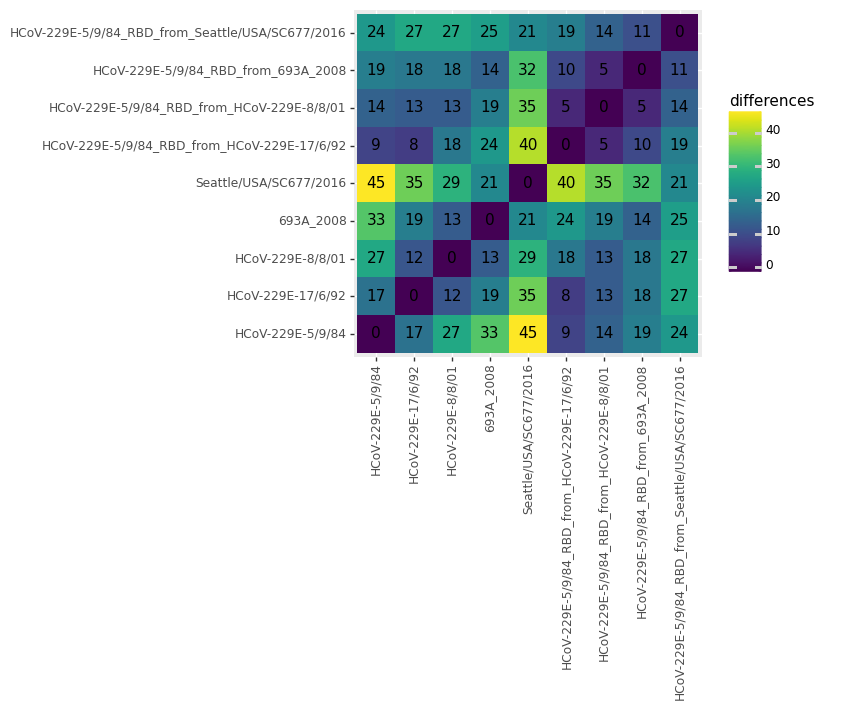

In [10]:
prot_pairs = list(itertools.product(prots_for_expts, prots_for_expts))
prot_names = [prot.id for prot in prots_for_expts]

df = (pd.DataFrame({'name_1': [tup[0].id for tup in prot_pairs],
                    'name_2': [tup[1].id for tup in prot_pairs],
                    'seq_1': [str(tup[0].seq) for tup in prot_pairs],
                    'seq_2': [str(tup[1].seq) for tup in prot_pairs],
                    })
      .assign(differences=lambda x: x.apply(lambda row: editdistance.eval(row['seq_1'], row['seq_2']),
                                         axis=1),
              name_1=lambda x: pd.Categorical(x['name_1'], prot_names, ordered=True),
              name_2=lambda x: pd.Categorical(x['name_2'], prot_names, ordered=True),
              )
      )

p = (ggplot(df) +
     aes('name_1', 'name_2', fill='differences', label='differences') +
     geom_tile() +
     geom_text() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.5 * len(prot_names), 0.5 * len(prot_names)),
           ) +
     xlab('') +
     ylab('')
     )

_ = p.draw()

print(f"Saving heat map to {config['seqs_for_expts_diffs']}")
p.save(config['seqs_for_expts_diffs'], verbose=False)

## Write proteins to file
Write the proteins to a FASTA file, and also individually to Genbank files:

In [11]:
print(f"Writing all proteins for experiments to {config['prots_for_expts']}")
_ = Bio.SeqIO.write(prots_for_expts, config['prots_for_expts'], 'fasta')

print(f"Writing proteins individually in Genbank format to {config['seqs_for_expts_dir']}")
for prot in prots_for_expts:
    name = prot.id.replace('/', '_')
    fname = os.path.join(config['seqs_for_expts_dir'], f"{name}.gp")
    print(f"  Writing {fname}")
    if 'RBD' in prot.id:
        prot.id = 'RBD_chimera'  # hack to avoid excessively long LOCUS names
    _ = Bio.SeqIO.write(prot, fname, 'genbank')

Writing all proteins for experiments to results/seqs_for_expts/prots.fasta
Writing proteins individually in Genbank format to results/seqs_for_expts
  Writing results/seqs_for_expts/HCoV-229E-5_9_84.gp
  Writing results/seqs_for_expts/HCoV-229E-17_6_92.gp
  Writing results/seqs_for_expts/HCoV-229E-8_8_01.gp
  Writing results/seqs_for_expts/693A_2008.gp
  Writing results/seqs_for_expts/Seattle_USA_SC677_2016.gp
  Writing results/seqs_for_expts/HCoV-229E-5_9_84_RBD_from_HCoV-229E-17_6_92.gp
  Writing results/seqs_for_expts/HCoV-229E-5_9_84_RBD_from_HCoV-229E-8_8_01.gp
  Writing results/seqs_for_expts/HCoV-229E-5_9_84_RBD_from_693A_2008.gp
  Writing results/seqs_for_expts/HCoV-229E-5_9_84_RBD_from_Seattle_USA_SC677_2016.gp
